## Multi-label prediction with Planet Amazon dataset

In [0]:
!pip install torch===1.4.0 torchvision===0.5.0 -f https://download.pytorch.org/whl/torch_stable.html

In [0]:
from fastai.vision import *

In [0]:
# !curl https://course.fast.ai/setup/colab | bash
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# ! {sys.executable} -m pip install kaggle --upgrade

In [0]:
dest =  '/root/.fastai/data/planet/'
% cd /content/gdrive/My\ Drive
! ls -a

/content/gdrive/My Drive
'Colab Notebooks'   fastai-v3				 train-jpg.tar.7z
 export.pkl	   'How to get started with Drive.pdf'


In [0]:
# mv train-jpg.tsr.7z ~/.fastai/data/planet/
!mv "/content/gdrive/My Drive/test-jpg-additional.tar.7z" "/root/.fastai/data/planet/"

In [0]:
ls -a

In [0]:
! mkdir -p ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
! mv kaggle.json ~/.kaggle/

# For Windows, uncomment these two commands
# ! mkdir %userprofile%\.kaggle
# ! move kaggle.json %userprofile%\.kaggle

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [0]:
ls -a

./  ../  train_v2.csv


In [0]:
from google.colab import files
uploaded = files.upload()

Saving train_v2.csv to train_v2.csv


In [0]:
path = Config.data_path()/'planet'
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/root/.fastai/data/planet')

In [0]:
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p {path}  
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv -p {path}  
! unzip -q -n {path}/train_v2.csv.zip -d {path}

404 - Not Found
404 - Not Found
unzip:  cannot find or open /root/.fastai/data/planet/train_v2.csv.zip, /root/.fastai/data/planet/train_v2.csv.zip.zip or /root/.fastai/data/planet/train_v2.csv.zip.ZIP.


In [0]:
!unzip Kaggle-planet-train-tif.torrent.zip

Archive:  Kaggle-planet-train-tif.torrent.zip
  inflating: Kaggle-planet-train-tif.torrent  


To extract the content of this file, we'll need 7zip, so uncomment the following line if you need to install it (or run `sudo apt install p7zip-full` in your terminal).

In [0]:
#  ! conda install --yes --prefix {sys.prefix} -c haasad eidl7zip

/bin/bash: conda: command not found


And now we can unpack the data (uncomment to run - this might take a few minutes to complete).

In [0]:
! 7za -bd -y -so x {path}/train-jpg.tar.7z | tar xf - -C {path.as_posix()}

## Multiclassification

In [0]:
%cd /root/.fastai/data/planet/
!ls -a

/root/.fastai/data/planet
.  ..  train-jpg  train-jpg.tar.7z  train_v2.csv


In [0]:
df = pd.read_csv(path/'train_v2.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


To put this in a `DataBunch` while using the [data block API](https://docs.fast.ai/data_block.html), we then need to using `ImageList` (and not `ImageDataBunch`). This will make sure the model created has the proper loss function to deal with the multiple classes.

In [0]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

We use parentheses around the data block pipeline below, so that we can use a multiline statement without needing to add '\\'.

In [0]:
np.random.seed(42)
src = (ImageList.from_csv(path, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' '))

In [0]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

`show_batch` still works, and show us the different labels separated by `;`.

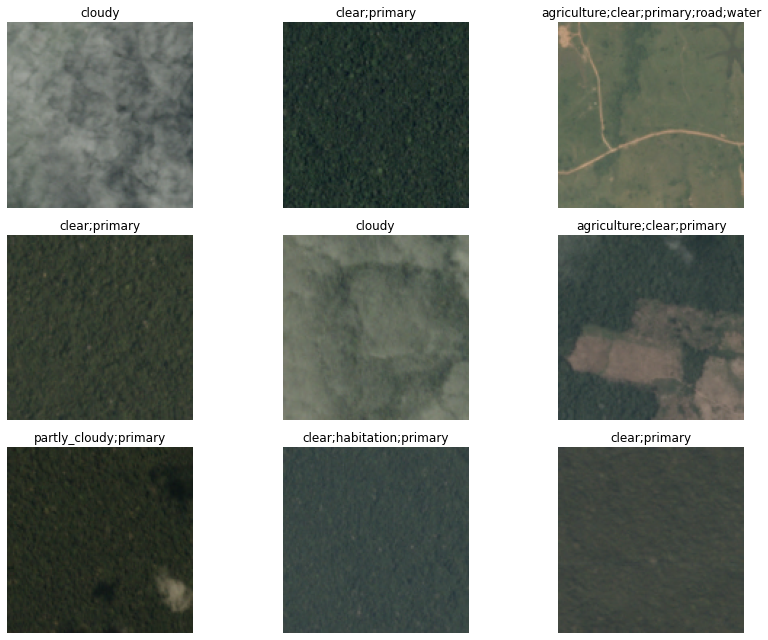

In [0]:
data.show_batch(rows=3, figsize=(12,9))

In [0]:
arch = models.resnet50

In [0]:
?? accuracy_thresh

In [0]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, arch, metrics=[acc_02, f_score])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


We use the LR Finder to pick a good learning rate.

In [0]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


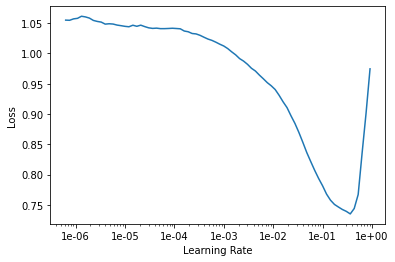

In [0]:
learn.recorder.plot()

Then we can fit the head of our network.

In [0]:
lr = 0.01

In [0]:
?? slice

In [0]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.137297,0.120507,0.950034,0.892945,02:46
1,0.109139,0.099513,0.955448,0.913227,02:43
2,0.101194,0.092165,0.951452,0.919482,02:40
3,0.096290,0.087374,0.954678,0.923597,02:37
4,0.092777,0.086348,0.956001,0.924998,02:37


In [0]:
learn.save('stage-1-rn50')

...And fine-tune the whole model:

In [0]:
learn.unfreeze()

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.097016,0.094868,0.952004,0.916215
2,0.095774,0.088899,0.954540,0.922340
3,0.090646,0.085958,0.959249,0.924921
4,0.085097,0.083291,0.958849,0.928195
5,0.079197,0.082855,0.958602,0.928259


In [0]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.098345,0.092971,0.954729,0.916893,02:50
1,0.096969,0.089448,0.953624,0.922264,02:49
2,0.093490,0.087575,0.956269,0.924413,02:47
3,0.083786,0.082994,0.958209,0.928585,02:47
4,0.079275,0.082861,0.957664,0.928366,02:47


In [0]:
learn.save('stage-2-rn50')

In [0]:
data = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [0]:
learn.freeze()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


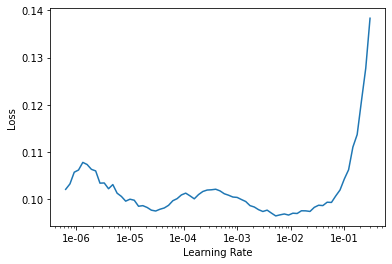

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr=1e-2/2

In [0]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.086680,0.087475,0.956131,0.923978,05:30
1,0.086658,0.084660,0.957475,0.927751,05:20
2,0.084990,0.082834,0.958566,0.928256,05:25
3,0.084172,0.082034,0.958834,0.929869,05:40
4,0.077718,0.081384,0.959772,0.930075,05:38


In [0]:
learn.save('stage-1-256-rn50')

In [0]:
learn.unfreeze()

In [0]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.083734,0.086300,0.956378,0.926451,07:06
1,0.084274,0.086440,0.956654,0.923988,07:05
2,0.082214,0.081400,0.958776,0.931282,07:04
3,0.077132,0.081310,0.959452,0.928900,07:05
4,0.075272,0.080830,0.959946,0.931624,07:04


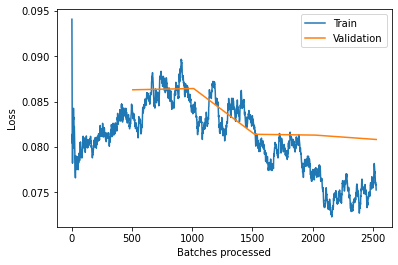

In [0]:
learn.recorder.plot_losses()

In [0]:
learn.save('stage-2-256-rn50')

You won't really know how you're going until you submit to Kaggle, since the leaderboard isn't using the same subset as we have for training. But as a guide, 50th place (out of 938 teams) on the private leaderboard was a score of `0.930`.

In [0]:
learn.export()

## fin

In [0]:
#! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg.tar.7z -p {path}  
! 7za -bd -y -so x {path}/test-jpg.tar.7z | tar xf - -C {path}
#! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg-additional.tar.7z -p {path}  
! 7za -bd -y -so x {path}/test-jpg-additional.tar.7z | tar xf - -C {path}

In [0]:
test = ImageList.from_folder(path/'test-jpg').add(ImageList.from_folder(path/'test-jpg-additional'))
len(test)

61191

In [0]:
learn = load_learner(path, test=test)
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [0]:
thresh = 0.2
labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]

In [0]:
labelled_preds[:5]

['partly_cloudy primary',
 'clear primary',
 'clear primary water',
 'agriculture bare_ground clear cultivation primary water',
 'partly_cloudy primary']

In [0]:
fnames = [f.name[:-4] for f in learn.data.test_ds.items]

In [0]:
df = pd.DataFrame({'image_name':fnames, 'tags':labelled_preds}, columns=['image_name', 'tags'])

In [0]:
df.to_csv(path/'submission.csv', index=False)

In [0]:
!cp  "/root/.fastai/data/planet/export.pkl" "/content/gdrive/My Drive/Colab Notebooks" 

In [0]:
dest=Path(base_dir + "models/planet/")
try:
  dest.mkdir(parents=True, exist_ok=False)
except FileExistsError:
  print ('File Already Exists')

learn.save(dest/'stage-2-256-rn50')

In [0]:
! kaggle competitions submit planet-understanding-the-amazon-from-space -f {path/'submission.csv'} -m "My submission"

100%|██████████████████████████████████████| 2.18M/2.18M [00:02<00:00, 1.05MB/s]
Successfully submitted to Planet: Understanding the Amazon from Space

Public Leaderboard score: 0.93xxx (Top 5%)
